# Polynomial Model

In [1]:
import numpy as np
import pandas as pd

from pystatplottools.pdf_env.loading_figure_mode import loading_figure_mode
fma, plt = loading_figure_mode(develop=True) # develop=False will export the generated figures as pngs into "./data/RectangleData"
plt.style.use('seaborn-dark-palette')

if 'root_dir' not in locals():
    # Navigate to simulations/PolynomialModel directory as simulation root directory
    import os
    os.chdir("../simulations/PolynomialModel")
    root_dir = os.getcwd()

# To be able to compute custom measures
import sys
sys.path.append("./../../python_scripts")
    
mcmc_model_dir = "PolynomialModelLangevin/"
mcmc_data_dir = root_dir + "/data/" + mcmc_model_dir
mcmc_results_dir = root_dir + "/results/" + mcmc_model_dir

data_dir = root_dir + "/data/" + mcmc_model_dir
results_dir = root_dir + "/results/" + mcmc_model_dir

## MCMC Results

### Expectation Values

For the simulation with a single Markov Chain

In [2]:
from mcmctools.modes.expectation_value import load_expectation_value_results
expectation_values = load_expectation_value_results(files_dir="PolynomialModelLangevin")
expectation_values

Quantity,ExpVal,Error,ExpVal,Error
Observable,Mean,Mean,SecondMoment,SecondMoment
default,,,,
default,-0.001092,0.68381,0.467597,0.560487


## Data Evaluation with the pystatplottools Library

### Histogram of the Samples

In [3]:
# Load all data
from mcmctools.loading.loading import load_data

# skipcols=[] Can be used to load only certain columns of the different files
data, filenames = load_data(files_dir=mcmc_model_dir, running_parameter="default",
                            identifier="expectation_value")  # , skipcols=["Config"])
from mcmctools.utils.json import load_configs
sim_params, execution_params, running_parameter = load_configs(
    files_dir=mcmc_model_dir, mode="expectation_value", project_base_dir="./")
data

Mean    Config
default sample_num                    
default 0          -0.571449 -0.571449
        1          -0.117243 -0.117243
        2          -0.177674 -0.177674
        3          -0.070300 -0.070300
        4          -0.459535 -0.459535
...                      ...       ...
        999995      0.423382  0.423382
        999996      0.110337  0.110337
        999997      0.161935  0.161935
        999998      0.017065  0.017065
        999999      0.093581  0.093581

[1000000 rows x 2 columns]

#### Compute Energy / Action

In [4]:
polynomial_action = lambda x, a, b, c: a / 4.0 * np.power(x, 4.0) + b / 2.0 * np.power(x, 2.0) + c
data["Action"] = data["Config"].apply(lambda x: polynomial_action(x, 1.0, 1.0, 0.0))
data

Mean    Config    Action
default sample_num                              
default 0          -0.571449 -0.571449  0.189936
        1          -0.117243 -0.117243  0.006920
        2          -0.177674 -0.177674  0.016033
        3          -0.070300 -0.070300  0.002477
        4          -0.459535 -0.459535  0.116735
...                      ...       ...       ...
        999995      0.423382  0.423382  0.097659
        999996      0.110337  0.110337  0.006124
        999997      0.161935  0.161935  0.013283
        999998      0.017065  0.017065  0.000146
        999999      0.093581  0.093581  0.004398

[1000000 rows x 3 columns]

In [5]:
from pystatplottools.distributions.marginal_distribution import MarginalDistribution

histograms = MarginalDistribution(data=data)

range_min, range_max = histograms.extract_min_max_range_values(["Config", "Action"])
histograms.compute(
    axes_indices=["Config", "Action"],
    range_min=[range_min[0], 0.0001],
    range_max=range_max,
    nbins=[10, 20],
    statistic='probability',
    bin_scales=['linear', 'logarithmic']
)

linearized_histograms = histograms.linearize(
    order_by_bin=True,
    bin_alignment="center"
)
linearized_histograms

Not all data points are in the given ranges


bin_num_and_dfs       bin   default
statistics idx                     
Config     0    -2.228199  0.000139
           1    -1.743480  0.007658
           2    -1.258762  0.063444
           3    -0.774044  0.167428
           4    -0.289325  0.237636
           5     0.195393  0.243207
           6     0.680112  0.185838
           7     1.164830  0.081422
           8     1.649548  0.012853
           9     2.134267  0.000375
Action     0     0.000134  0.005060
           1     0.000241  0.006749
           2     0.000433  0.009007
           3     0.000778  0.011928
           4     0.001399  0.016086
           5     0.002514  0.021526
           6     0.004518  0.028677
           7     0.008120  0.037951
           8     0.014595  0.050064
           9     0.026230  0.065129
           10    0.047142  0.083446
           11    0.084727  0.102928
           12    0.152276  0.120098
           13    0.273680  0.129725
           14    0.491873  0.123378
           15    0.884023  0.096204
           16    1.588818  0.055785
           17    2.855517  0.018821
           18    5.132102  0.002695
           19    9.223715  0.000081

#### Visualization

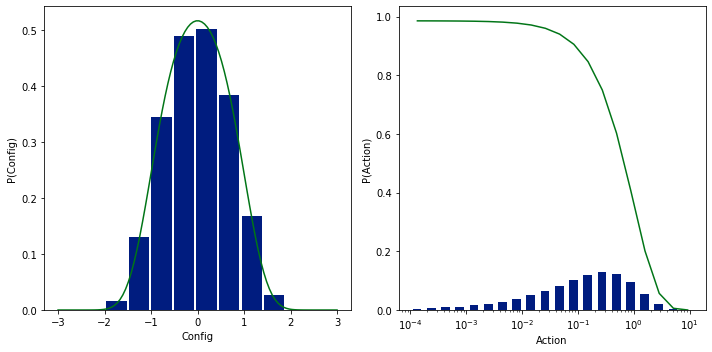

In [6]:
from pystatplottools.utils.bins_and_alignment import revert_align_bins


fig, axes = fma.newfig(1.8, nrows=1, ncols=2, ratio=0.7, figsize=(10, 5))

# Config Distribution

binedges = revert_align_bins(
    data_range=linearized_histograms.loc["Config"]["bin"].values,
    bin_alignment="center"
)
density_distribution = linearized_histograms.loc["Config"]["default"].values / (binedges[1:] - binedges[:-1])

width = 0.9 * (binedges[1:] - binedges[:-1])

axes[0].bar(
    x=linearized_histograms.loc["Config"]["bin"].values,
    height=density_distribution,
    width=width
)

x = np.linspace(-3, 3, 100)
boltzmann_weight = np.exp(-1.0 * polynomial_action(x, 1.0, 1.0, 0.0))
norm = np.sum(boltzmann_weight * (x[1] - x[0]))
boltzmann_weight /= np.sum(boltzmann_weight * (x[1] - x[0]))
axes[0].plot(x, boltzmann_weight, color="C{}".format(1))

axes[0].set_xlabel("Config")
axes[0].set_ylabel("P(Config)")

# Energy Distribution

binedges = revert_align_bins(
    data_range=linearized_histograms.loc["Action"]["bin"].values,
    bin_alignment="center",
    bin_scale="logarithmic"
)

width = 0.6 * (binedges[1:] - binedges[:-1])

density_distribution = linearized_histograms.loc["Action"]["default"].values #  / (binedges[1:] - binedges[:-1])

axes[1].bar(
    x=linearized_histograms.loc["Action"]["bin"].values,
    height=density_distribution,
    width=width
)

# Add Boltzmann distribution
action_values = linearized_histograms.loc["Action"]["bin"].values
action_values_bins = revert_align_bins(
    data_range=action_values,
    bin_alignment="center",
    bin_scale="logarithmic"
)
boltzmann_weight = np.exp(-1.0 * action_values) # / (action_values)
boltzmann_weight /= np.sum(boltzmann_weight * (action_values_bins[1:] - action_values_bins[:-1]))
axes[1].plot(action_values, boltzmann_weight, color="C{}".format(1))

axes[1].set_xlabel("Action")
axes[1].set_ylabel("P(Action)")
axes[1].set_xscale("Log")
# axes[1].set_yscale("Log")

plt.tight_layout()

fma.savefig(results_dir, "histograms")

## Configurations as Pytorch Dataset

We show how the mcmc configurations can be stored and loaded as a .pt file.

(See also python_scripts/loading_configurations.py and python_scripts/pytorch_data_generation.py)

Currently, this only works if a running_parameter has been defined. We therefore load the data from our second simulation.

### Preparation

In [7]:
data_generator_args = {
    # ConfigDataGenerator Args
    "data_type": "target_param",
    # Args for ConfigurationLoader
    "path": mcmc_data_dir,
    "total_number_of_data_per_file": 100000,
    "identifier": "expectation_value",
    "labels": ["Mean"],
    "chunksize": 400  # If no chunksize is given, all data is loaded at once
}

# Prepare in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import prepare_in_memory_dataset
from mcmctools.pytorch.data_generation.datagenerationroutines import data_generator_factory

prepare_in_memory_dataset(
    root=data_dir,
    batch_size=128,
    data_generator_args=data_generator_args,
    data_generator_name="BatchConfigDataGenerator",
    data_generator_factory=data_generator_factory
)

Random seed is set by np.random.seed()


### Generating and Loading the Dataset

In [8]:
# Load in memory dataset
from pystatplottools.pytorch_data_generation.data_generation.datagenerationroutines import load_in_memory_dataset

# The dataset is generated and stored as a .pt file in the data_dir/data directory the first time this function is called. Otherwise the .pt is loaded.
data_loader = load_in_memory_dataset(
    root=data_dir, batch_size=128, data_generator_factory=data_generator_factory, slices=None, shuffle=True,
    num_workers=0, rebuild=False
    # sample_data_generator_name="ConfigDataGenerator"  # optional: for a generation of new samples
)

# Load training data
for batch_idx, batch in enumerate(data_loader):
    data, target = batch
    # print(batch_idx, len(data))

RDKit WARNING: [13:46:14] Enabling RDKit 2019.09.1b1 jupyter extensions


Processing...
Random seed is set by np.random.seed()
Done!
